# Anime Face Classification

Project for IBM AI Engineering certification course.

## Modules

In [1]:
import os
import io
import zipfile
import requests
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import kagglehub

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

## Dataset
Original Dataset used in 'AniWho' study: https://arxiv.org/pdf/2208.11012v3

Download: https://www.kaggle.com/datasets/thedevastator/anime-face-dataset-by-character-name

In [2]:
images = {'anastasia': [], 'takao': []}

path = Path(kagglehub.dataset_download("thedevastator/anime-face-dataset-by-character-name")) / 'dataset'
for key, l in images.items():
  for f in path.glob(f'{key}*/*.jpg'):
    img = Image.open(f).convert('RGB')
    l.append(np.array(img))
  print(f'Loaded {len(l)} of {key} images')

100%|██████████| 57.9M/57.9M [00:00<00:00, 214MB/s]

Extracting files...


Loaded 75 of anastasia images
Loaded 75 of takao images


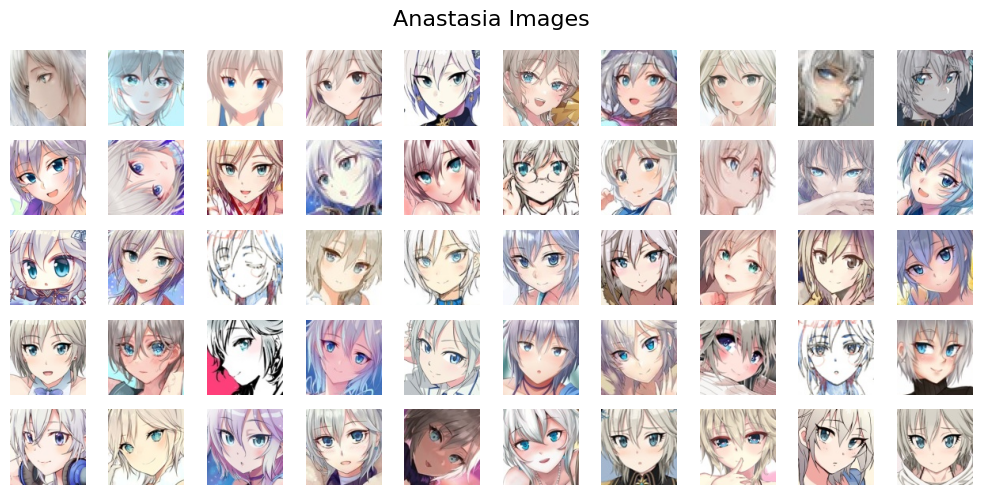

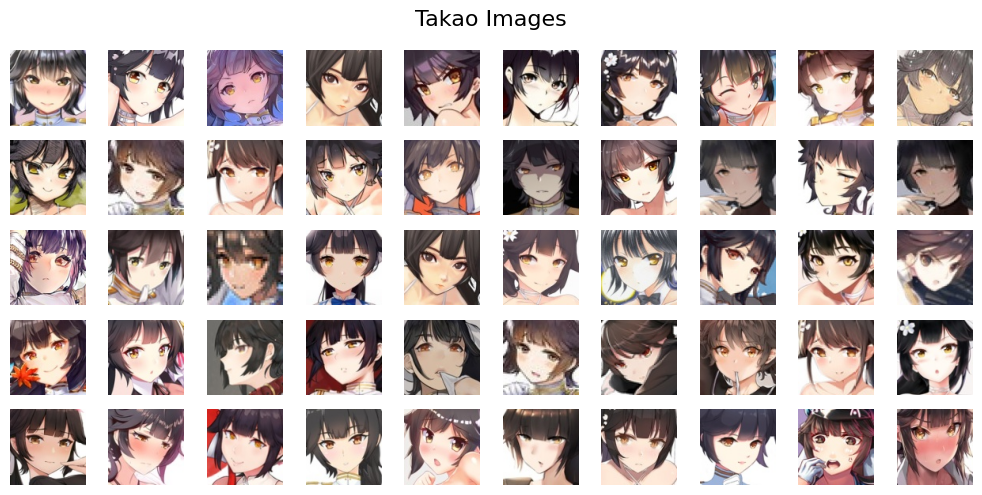

In [3]:
def plot_images(images, title):
    fig, axes = plt.subplots(5, 10, figsize=(10, 5))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(images['anastasia'], 'Anastasia Images')
plot_images(images['takao'], 'Takao Images')

## Models

In [4]:
class AnimeDataset(Dataset):
    def __init__(self, images, transform=None, classes=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes = classes

        for label, class_name in enumerate(self.classes):
            for img in images[class_name]:
                self.images.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = AnimeDataset(images, transform=transform, classes=['anastasia', 'takao'])

In [5]:

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

indices = list(range(len(dataset)))

train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

print("Train size:", len(train_indices))
print("Validation size:", len(val_indices))

Train size: 120
Validation size: 30


In [6]:
class AnimeCNN(nn.Module):
    def __init__(self, activation):
        super(AnimeCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        self.activ = activation

    def forward(self, x):
        x = self.pool(self.activ(self.conv1(x)))
        x = self.pool(self.activ(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = self.activ(self.fc1(x))
        x = self.fc2(x)
        return x

model_relu = AnimeCNN(nn.ReLU())
model_lrelu = AnimeCNN(nn.LeakyReLU())

def describe_model(model):
  print(model,'\n\n')

  input_tensor = torch.randn(1, 3, 64, 64)

  def print_size(module, input, output):
      print(f"{module.__class__.__name__} output size: {output.size()}")

  hooks = []
  for layer in model.children():
      hook = layer.register_forward_hook(print_size)
      hooks.append(hook)

  with torch.no_grad():
      output = model(input_tensor)
  print("Final output size:", output.size())

  for hook in hooks:
      hook.remove()

describe_model(model_relu)
#describe_model(model_lrelu)

AnimeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (activ): ReLU()
) 


Conv2d output size: torch.Size([1, 32, 64, 64])
ReLU output size: torch.Size([1, 32, 64, 64])
MaxPool2d output size: torch.Size([1, 32, 32, 32])
Conv2d output size: torch.Size([1, 64, 32, 32])
ReLU output size: torch.Size([1, 64, 32, 32])
MaxPool2d output size: torch.Size([1, 64, 16, 16])
Linear output size: torch.Size([1, 128])
ReLU output size: torch.Size([1, 128])
Linear output size: torch.Size([1, 2])
Final output size: torch.Size([1, 2])


## Training

In [7]:
num_epochs = 5

def train_model(
    model,
    criterion,
    optimizer,
    num_epochs = 5,
    verbose = True
):
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    if verbose:
      print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
  return train_losses, val_losses

In [8]:
train_losses_relu, val_losses_relu = train_model(
    model_relu,
    nn.CrossEntropyLoss(),
    optim.Adam(model_relu.parameters(), lr=0.001),
    num_epochs
  )

Epoch 1, Train Loss: 0.2856, Val Loss: 0.7877
Epoch 2, Train Loss: 0.0937, Val Loss: 0.0066
Epoch 3, Train Loss: 0.0215, Val Loss: 0.0344
Epoch 4, Train Loss: 0.0009, Val Loss: 0.0532
Epoch 5, Train Loss: 0.0002, Val Loss: 0.0134


In [9]:
train_losses_lrelu, val_losses_lrelu = train_model(
    model_lrelu,
    nn.CrossEntropyLoss(),
    optim.Adam(model_lrelu.parameters(), lr=0.001),
    num_epochs
  )

Epoch 1, Train Loss: 0.3098, Val Loss: 0.1524
Epoch 2, Train Loss: 0.0645, Val Loss: 0.1504
Epoch 3, Train Loss: 0.0174, Val Loss: 0.0854
Epoch 4, Train Loss: 0.0094, Val Loss: 0.0525
Epoch 5, Train Loss: 0.0071, Val Loss: 0.1100


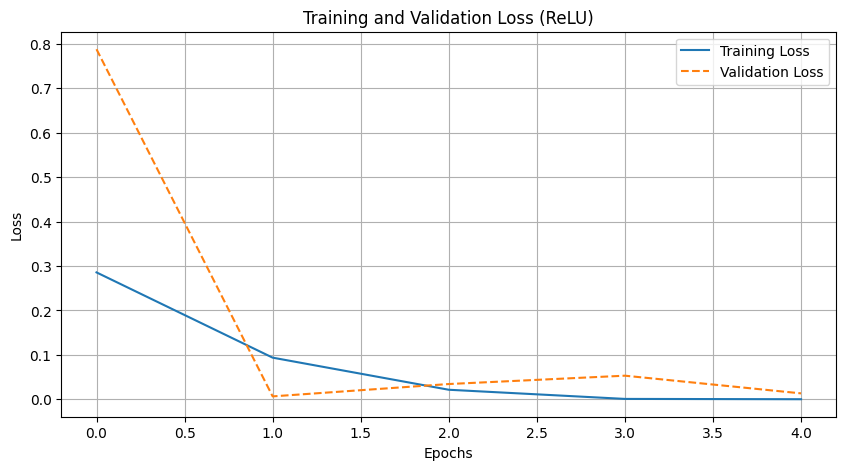

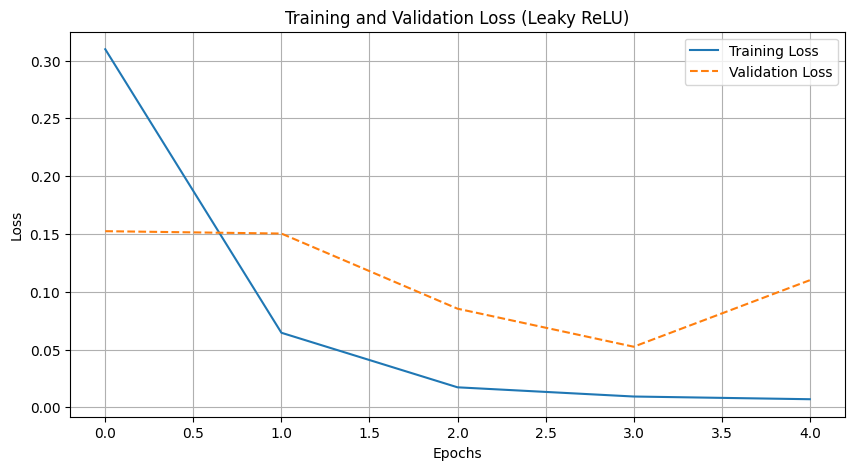

In [10]:
def plot_loss(train_losses, val_losses, title):
  plt.figure(figsize=(10, 5))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss', linestyle='--')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.title(title)
  plt.show()

plot_loss(train_losses_relu, val_losses_relu, 'Training and Validation Loss (ReLU)')
plot_loss(train_losses_lrelu, val_losses_lrelu, 'Training and Validation Loss (Leaky ReLU)')

## Evaluation

In [11]:
def eval_model(model, val_loader):
  def imshow(img, ax):
      img = img / 2 + 0.5
      npimg = img.numpy()
      ax.imshow(np.transpose(npimg, (1, 2, 0)))
      ax.axis('off')

  model.eval()

  data_iter = iter(val_loader)
  images, labels = next(data_iter)
  outputs = model(images)
  _, predicted = torch.max(outputs, 1)

  num_images = len(images)
  num_cols = 10
  num_rows = 2

  fig, axs = plt.subplots(num_rows, num_cols * 2, figsize=(20, num_rows))

  for idx in range(num_images):
      row = idx // num_cols
      col = (idx % num_cols) * 2

      imshow(images[idx].cpu(), axs[row, col])

      axs[row, col + 1].text(0.5, 0.5, f"Actual: {labels[idx].item()}\nPredicted: {predicted[idx].item()}",
                            horizontalalignment='center', verticalalignment='center', fontsize=12)
      axs[row, col + 1].axis('off')

  for idx in range(num_images, num_rows * num_cols):
      row = idx // num_cols
      col = (idx % num_cols) * 2
      axs[row, col].axis('off')
      axs[row, col + 1].axis('off')

  correct = 0
  total = 0

  with torch.no_grad():
      for data in val_loader:
          images, labels = data
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          print(f'correct: {correct}, total: {total}')

  print(f'Validation Accuracy: {100 * correct / total:.2f}%')

  plt.tight_layout()
  plt.show()

## ReLU CNN

correct: 20, total: 20
correct: 30, total: 30
Validation Accuracy: 100.00%


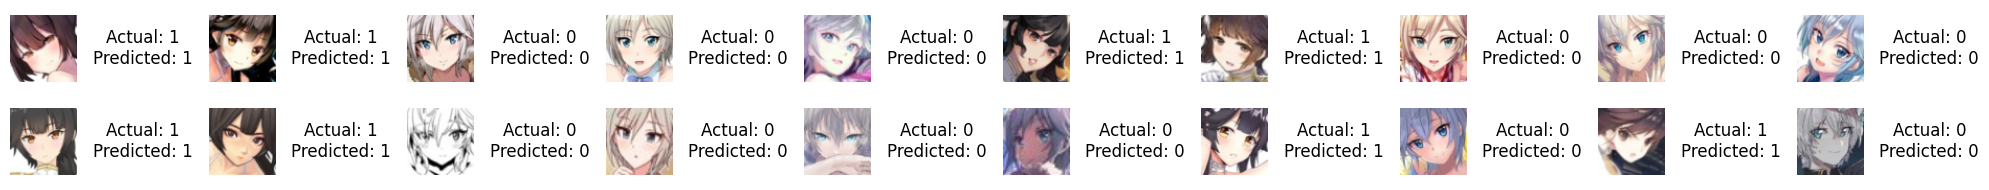

In [12]:
eval_model(model_relu, val_loader)

## Leaky ReLU CNN

correct: 20, total: 20
correct: 29, total: 30
Validation Accuracy: 96.67%


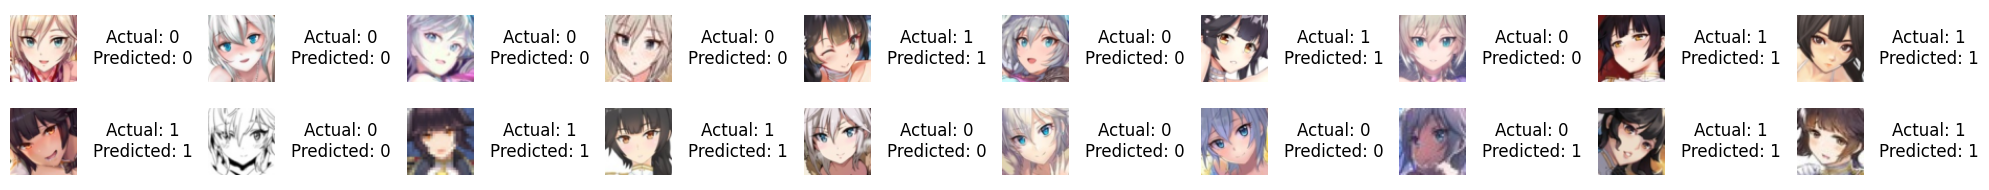

In [13]:
eval_model(model_lrelu, val_loader)